In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("src")

from poisson_solver import PoissonSolver
from structure_manager import StructureManager

# 電極のテスト

In [89]:
nx, ny, nz = 21, 21, 21
h = 1e-9

epsilon_0 = 8.854e-12  # Vacuum permittivity
epsilon = np.ones((nx, ny, nz)) * 11.7  # Si

electrode_mask = np.zeros((nx, ny, nz), dtype=bool)
k_electrode_bottom = nz - 2  # 電極底面のz-index
ew = 10
exmin, exmax = nx // 2 - ew // 2, nx // 2 + ew // 2  # position of electrode in x
eymin, eymax = ny // 2 - ew // 2, ny // 2 + ew // 2  # position of electrode in y
electrode_mask[eymin:eymax+1, exmin:exmax+1, k_electrode_bottom:] = True
electrode_mask[eymin, exmin, k_electrode_bottom:] = False
electrode_mask[eymin, exmax, k_electrode_bottom:] = False
electrode_mask[eymax, exmin, k_electrode_bottom:] = False
electrode_mask[eymax, exmax, k_electrode_bottom:] = False

electrode_voltages = np.zeros((nx, ny, nz))
electrode_voltage = -0.5
electrode_voltages[electrode_mask] = electrode_voltage

boundary_conditions = {
    'z_top': {'type': 'neumann', 'value': 0.0},
    'z_bottom': {'type': 'dirichlet', 'value': 0.0},
    'x_sides': {'type': 'dirichlet', 'value': 0.0},
    'y_sides': {'type': 'dirichlet', 'value': 0.0},
}

solver = PoissonSolver(
    epsilon=epsilon,
    grid_spacing=h,
    boundary_conditions=boundary_conditions,
    omega=1.2,
    tolerance=1e-6,
    max_iterations=50,
    electrode_mask=electrode_mask,
    electrode_voltages=electrode_voltages,
)

In [90]:
# phi, info = solver.solve()
# x = np.linspace((nx-1) // 2 * h, (nx-1) // 2 * h, nx)
# y = np.linspace((ny-1) // 2 * h, (ny-1) // 2 * h, ny)
# z = np.linspace(-(nz - 1) * h, 0, nz)
# X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
# phi_initial = epsilon_0 * electrode_voltage / (h * (k_electrode_bottom)) * Z
phi_initial = np.zeros((nx, ny, nz))
phi_initial[6:15, 6:15, k_electrode_bottom-3:] = electrode_voltage
phi, info = solver.solve(phi_initial=phi_initial)

Iteration 10: Residual = 7.678264e-01
Iteration 20: Residual = 1.027349e+01
Iteration 30: Residual = 2.030075e+02
Iteration 40: Residual = 4.413577e+03
Iteration 50: Residual = 1.010085e+05


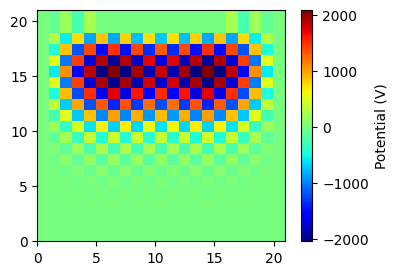

In [91]:
plt.figure(figsize=(4, 3))
plt.pcolor(phi[:, ny//2, :].T, cmap='jet')
plt.colorbar(label='Potential (V)')

In [71]:
rho = np.zeros((nx, ny, nz))
phi2 = solver._sor_iteration(phi, rho)

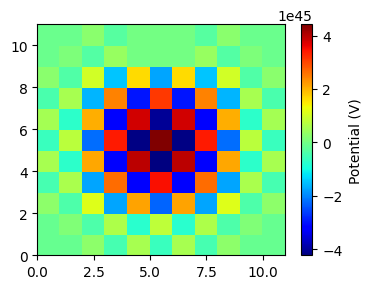

In [72]:
plt.figure(figsize=(4, 3))
plt.pcolor(phi2[:, ny//2, :].T, cmap='jet')
plt.colorbar(label='Potential (V)')

# 平行平板コンデンサ

In [2]:
nx, ny, nz = 3, 3, 11
h = 2e-9

epsilon = np.ones((nx, ny, nz)) * 3.9  # SiO2

boundary_conditions = {
    'z_top': {'type': 'dirichlet', 'value': 1.0},  # 1V
    'z_bottom': {'type': 'dirichlet', 'value': 0.0},  # 0V
    'x_sides': {'type': 'neumann', 'value': 0.0},
    'y_sides': {'type': 'neumann', 'value': 0.0},
}

solver = PoissonSolver(
    epsilon=epsilon,
    grid_spacing=h,
    boundary_conditions=boundary_conditions,
    omega=1.5,
    tolerance=1e-8,
    max_iterations=5000,
)

In [3]:
phi, info = solver.solve()

Iteration 10: Residual = 5.846971e-02
Iteration 20: Residual = 3.581534e-02
Iteration 30: Residual = 2.625501e-02
Iteration 40: Residual = 2.019244e-02
Iteration 50: Residual = 1.570892e-02
Iteration 60: Residual = 1.225254e-02
Iteration 70: Residual = 9.562118e-03
Iteration 80: Residual = 7.463406e-03
Iteration 90: Residual = 5.825487e-03
Iteration 100: Residual = 4.547053e-03
Iteration 110: Residual = 3.549183e-03
Iteration 120: Residual = 2.770300e-03
Iteration 130: Residual = 2.162347e-03
Iteration 140: Residual = 1.687812e-03
Iteration 150: Residual = 1.317415e-03
Iteration 160: Residual = 1.028303e-03
Iteration 170: Residual = 8.026377e-04
Iteration 180: Residual = 6.264957e-04
Iteration 190: Residual = 4.890088e-04
Iteration 200: Residual = 3.816939e-04
Iteration 210: Residual = 2.979297e-04
Iteration 220: Residual = 2.325478e-04
Iteration 230: Residual = 1.815143e-04
Iteration 240: Residual = 1.416803e-04
Iteration 250: Residual = 1.105880e-04
Iteration 260: Residual = 8.631901

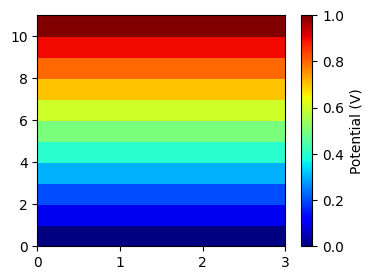

In [4]:
plt.figure(figsize=(4, 3))
plt.pcolor(phi[:, 0, :].T, cmap='jet')
plt.colorbar(label='Potential (V)')